## Objectif du notebook

Ce notebook a pour objectif de :
- Comprendre la structure et la granularité des données disponibles
- Identifier les variables clés pour l’analyse de la performance et du risque de blessure
- Mettre en évidence les défis liés à l’agrégation journalière (prochaine étape) et à la qualité des données

In [1]:
import os
from pathlib import Path
from datetime import datetime
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Set plotting style
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

In [2]:
# Root path of the project
PROJECT_ROOT = Path("..")

DATA_RAW = PROJECT_ROOT / "data" / "raw"

## Participant Overview

In [3]:
participants_path = DATA_RAW / "participant-overview.xlsx"
participants_df = pd.read_excel(participants_path, header=1)
print(participants_df.columns)
participants_df.head()


Index(['Participant ID', 'Age', 'Height', 'Gender', 'A or B person',
       'Max heart rate', 'Date', 'Minutes', 'Seconds', 'Stride walk',
       'Stride run'],
      dtype='object')


,Participant ID,Age,Height,Gender,A or B person,Max heart rate,Date,Minutes,Seconds,Stride walk,Stride run
0,p01,48,195,male,A,182,2019-11-26 00:00:00,29,33,80.9,102.9
1,p02,60,180,male,A,169,2019-12-15 00:00:00,23,51,74.7,92.4
2,p03,25,184,male,A,157,2019-12-30 00:00:00,33,22,NaN,NaN
3,p04,26,163,female,A,195,2019-11-19 00:00:00,22,13,67.3,110.2
4,p05,35,176,male,A,184,2019-12-23 00:00:00,32,40,73.0,94.3


Lors de l’importation du fichier participant-overview, la ligne d’en-tête
ne correspond pas à la première ligne du fichier Excel.
L’argument `header=1` est donc utilisé afin de lire correctement les noms de colonnes.


In [4]:
participants_df = participants_df.rename(columns={"Date": "date_1st_5km"})
participants_df["date_1st_5km"] = pd.to_datetime(participants_df["date_1st_5km"],errors="coerce")

In [5]:
available_participants = ["p01", "p03", "p05"]

participants_df = participants_df[participants_df["Participant ID"].isin(available_participants)].copy()
participants_df

,Participant ID,Age,Height,Gender,A or B person,Max heart rate,date_1st_5km,Minutes,Seconds,Stride walk,Stride run
0,p01,48,195,male,A,182,2019-11-26,29,33,80.9,102.9
2,p03,25,184,male,A,157,2019-12-30,33,22,NaN,NaN
4,p05,35,176,male,A,184,2019-12-23,32,40,73.0,94.3


In [6]:
participants_df["time_1st_5km_minutes"] = ( participants_df["Minutes"] +participants_df["Seconds"] / 60)
participants_df = participants_df.drop(columns=["Minutes","Seconds"])

participants_df

,Participant ID,Age,Height,Gender,A or B person,Max heart rate,date_1st_5km,Stride walk,Stride run,time_1st_5km_minutes
0,p01,48,195,male,A,182,2019-11-26,80.9,102.9,29.55
2,p03,25,184,male,A,157,2019-12-30,NaN,NaN,33.366667
4,p05,35,176,male,A,184,2019-12-23,73.0,94.3,32.666667


Le temps du premier test 5 km est initialement fourni sous forme de minutes et secondes.

Ces deux colonnes ont été combinées en une variable continue exprimée en minutes

(`time_1st_5km_minutes`) afin de faciliter l’interprétation.

## FITBIT

### Les calories
`calories.json` indique le nombre de calories brûlées par minute


chargement des calories du premier athlète p01

In [7]:
participant_id = "p01"
participants_path = DATA_RAW / participant_id
cal_path = participants_path / "fitbit" / "calories.json"

In [8]:
with open(cal_path, "r") as f:
    cal_data = json.load(f)

daily_calories_df = pd.DataFrame(cal_data)
daily_calories_df.insert(0, 'participant_id', participant_id)
daily_calories_df.head()

,participant_id,dateTime,value
0,p01,2019-11-01 00:00:00,1.39
1,p01,2019-11-01 00:01:00,1.39
2,p01,2019-11-01 00:02:00,1.39
3,p01,2019-11-01 00:03:00,1.39
4,p01,2019-11-01 00:04:00,1.39


In [9]:
# parser la colonne "dateTime" en datetime
daily_calories_df["date"] = pd.to_datetime(daily_calories_df["dateTime"])
daily_calories_df["calories"] = daily_calories_df["value"].astype(float)
daily_calories_df = daily_calories_df[["participant_id", "date", "calories"]]
daily_calories_df.head()

,participant_id,date,calories
0,p01,2019-11-01 00:00:00,1.39
1,p01,2019-11-01 00:01:00,1.39
2,p01,2019-11-01 00:02:00,1.39
3,p01,2019-11-01 00:03:00,1.39
4,p01,2019-11-01 00:04:00,1.39


In [10]:
print(daily_calories_df.describe())
print(daily_calories_df.isna().mean())

                                date       calories
count                         218880  218880.000000
mean   2020-01-15 23:59:29.999999488       2.505287
min              2019-11-01 00:00:00       0.280000
25%              2019-12-08 23:59:45       1.380000
50%              2020-01-15 23:59:30       1.520000
75%              2020-02-22 23:59:15       1.810000
max              2020-03-31 23:59:00      23.730000
std                              NaN       2.307729
participant_id    0.0
date              0.0
calories          0.0
dtype: float64


Les données des calories sont enregistrées à une granularité/freq d’une minute.<br>

On observe des valeurs relativement faibles et parfois constantes<br>
correspondant probablement à la dépense énergétique lors du repos<br>
auxquelles s’ajoutent des variations lors des périodes d’activité.<br>

Les calories représentant une quantité cumulative<br>
une agrégation journalière par somme sera physiologiquement pertinente<br>
pour la construction des features.


##### Calories brûlées par minute

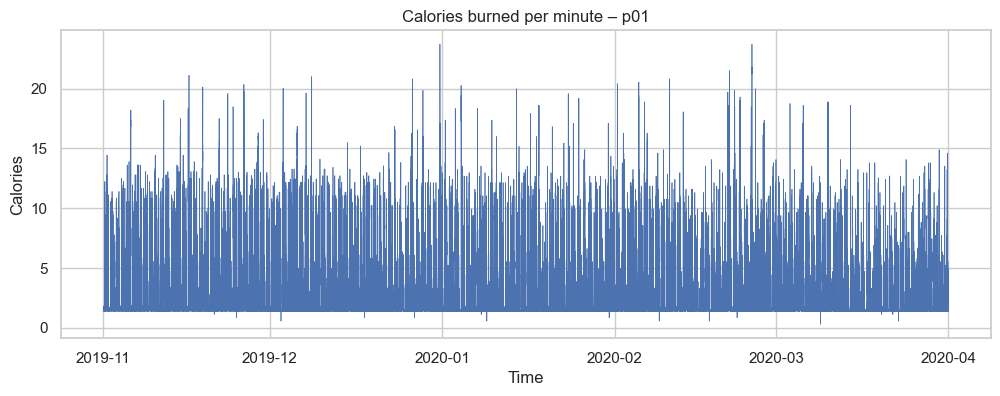

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(daily_calories_df["date"], daily_calories_df["calories"], linewidth=0.5)
plt.title(f"Calories burned per minute – {participant_id}")
plt.xlabel("Time")
plt.ylabel("Calories")
plt.show()

##### Calories brûlées par jour

In [12]:
# utils
def aggregate_daily_sum(df, datetime_col, value_col):
    """
    Agrège une série temporelle à une granularité journalière
    en sommant les valeurs.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame contenant les données temporelles
    datetime_col : str
        Nom de la colonne datetime
    value_col : str
        Nom de la colonne à agréger

    Returns
    -------
    pd.DataFrame
        DataFrame avec une ligne par jour
    """
    df = df.copy()
    df["date"] = df[datetime_col].dt.date

    daily_df = (
        df.groupby("date")[value_col]
        .sum()
        .reset_index()
    )

    return daily_df

In [13]:
daily_calories_df = aggregate_daily_sum(daily_calories_df, datetime_col="date", value_col="calories")
daily_calories_df.insert(0, "participant_id", participant_id)
print(daily_calories_df.head())
print(daily_calories_df.describe())

  participant_id        date  calories
0            p01  2019-11-01   4009.10
1            p01  2019-11-02   3533.56
2            p01  2019-11-03   3748.73
3            p01  2019-11-04   3353.38
4            p01  2019-11-05   3794.63
          calories
count   152.000000
mean   3607.612829
std     507.267269
min    2696.810000
25%    3230.167500
50%    3529.915000
75%    3942.717500
max    5225.820000


In [14]:
"""plt.figure(figsize=(12, 4))
plt.plot(
    daily_calories_df["date"],
    daily_calories_df["calories"],
    marker="o"
)
plt.title(f"Daily calories burned – {participant_id}")
plt.xlabel("Date")
plt.ylabel("Calories per day")
plt.show()"""

# utiliser plotly pour un rendu interactif
fig = px.line(
    daily_calories_df,
    x="date",
    y="calories",
    markers=True,
    title=f"Daily calories burned – {participant_id}",
    labels={
        "date": "Date",
        "calories": "Calories per day"
    }
)

fig.show()


##### Les calories des 3 participants

In [15]:
"""
# utils
def load_calories_df(participant_id, data_raw_path):
    
    cal_path = data_raw_path / participant_id / "fitbit" / "calories.json"

    with open(cal_path, "r") as f:
        cal_data = json.load(f)

    df = pd.DataFrame(cal_data)
    df.insert(0, 'participant_id', participant_id)
    df["dateTime"] = pd.to_datetime(df["dateTime"])
    df["calories"] = df["value"].astype(float)

    return df[["participant_id", "dateTime", "calories"]]
    """

'\n# utils\ndef load_calories_df(participant_id, data_raw_path):\n\n    cal_path = data_raw_path / participant_id / "fitbit" / "calories.json"\n\n    with open(cal_path, "r") as f:\n        cal_data = json.load(f)\n\n    df = pd.DataFrame(cal_data)\n    df.insert(0, \'participant_id\', participant_id)\n    df["dateTime"] = pd.to_datetime(df["dateTime"])\n    df["calories"] = df["value"].astype(float)\n\n    return df[["participant_id", "dateTime", "calories"]]\n    '

In [16]:
"""participants_ids = ["p01", "p03", "p05"]"""

'participants_ids = ["p01", "p03", "p05"]'

In [17]:
"""all_daily_calories = []

for participant_id in participants_ids:
    print(f"\n===== Participant {participant_id} =====")

    # Charger les données
    cal_df = load_calories_df(participant_id, DATA_RAW)

    # Stats minute-level
    #print("Minute-level calories:")
    #print(cal_df["calories"].describe())

    # Agrégation journalière (test)
    daily_calories_df = aggregate_daily_sum(
        cal_df,
        datetime_col="dateTime",
        value_col="calories"
    )

    print("\nDaily calories:")
    print(daily_calories_df["calories"].describe())

    # Ajouter l'ID participant (important pour la suite)
    daily_calories_df["participant_id"] = participant_id
    all_daily_calories.append(daily_calories_df)"""

"""    # Graphique individuel
    fig = px.line(
        daily_calories_df,
        x="date",
        y="calories",
        markers=True,
        title=f"Daily calories burned – {participant_id}",
        labels={
            "date": "Date",
            "calories": "Calories per day"
        }
    )
    fig.show()
"""

'    # Graphique individuel\n    fig = px.line(\n        daily_calories_df,\n        x="date",\n        y="calories",\n        markers=True,\n        title=f"Daily calories burned – {participant_id}",\n        labels={\n            "date": "Date",\n            "calories": "Calories per day"\n        }\n    )\n    fig.show()\n'

In [18]:
"""all_daily_calories_df = pd.concat(all_daily_calories, ignore_index=True)

fig = px.line(
    all_daily_calories_df,
    x="date",
    y="calories",
    color="participant_id",
    markers=True,
    title="Daily calories burned – comparison across participants",
    labels={
        "date": "Date",
        "calories": "Calories per day",
        "participant_id": "Participant"
    }
)

fig.show()"""


'all_daily_calories_df = pd.concat(all_daily_calories, ignore_index=True)\n\nfig = px.line(\n    all_daily_calories_df,\n    x="date",\n    y="calories",\n    color="participant_id",\n    markers=True,\n    title="Daily calories burned – comparison across participants",\n    labels={\n        "date": "Date",\n        "calories": "Calories per day",\n        "participant_id": "Participant"\n    }\n)\n\nfig.show()'

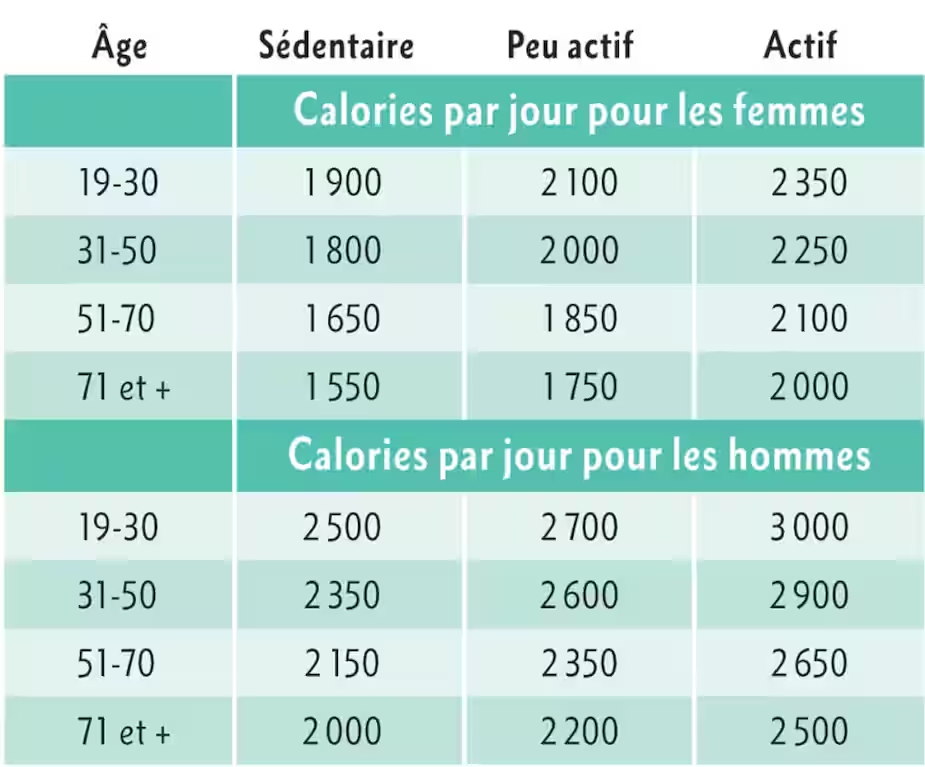

L’analyse du nombre des calories journalière brulées met en évidence des profils <br>
de charge distincts entre les athlètes.

Le participant p01 présente une charge élevée et relativement stable
avec des journées pouvant dépasser 5 000 cal <br>
suggérant un volume d’entraînement important et régulier.

À l’inverse, le participant p03 qui montre une dépense énergétique plus faible<br>
avec de longues périodes proches du métabolisme de base et des pics ponctuels d’activité.<br>

Le participant p05 se situe dans une position intermédiaire,<br>
avec une alternance plus équilibrée entre charge et récupération.

Ces différences inter-individuelles soulignent la nécessité d’une modélisation<br>
personnalisée du risque de blessure et de la performance en tenant compte à la fois du niveau de charge et de sa variabilité temporelle.


### Les distances
`distance.json` donne la distance parcourue par minute (semblent être en centimètres)

In [19]:
participant_id = "p01"
participants_path = DATA_RAW / participant_id
cal_path = participants_path / "fitbit" / "distance.json"

In [20]:
with open(cal_path, "r") as f:
    dist_data = json.load(f)

daily_distance_df = pd.DataFrame(dist_data)
# Ajouter l’ID participant
daily_distance_df.insert(0, 'participant_id', participant_id)
daily_distance_df.head()

,participant_id,dateTime,value
0,p01,2019-11-01 00:00:00,0
1,p01,2019-11-01 00:01:00,0
2,p01,2019-11-01 00:02:00,0
3,p01,2019-11-01 00:03:00,0
4,p01,2019-11-01 00:04:00,0


In [21]:
# parser la colonne "dateTime" en datetime
daily_distance_df["date"] = pd.to_datetime(daily_distance_df["dateTime"])
daily_distance_df["distance"] = daily_distance_df["value"].astype(float)
daily_distance_df = daily_distance_df[["participant_id", "date", "distance"]]
daily_distance_df.head()

,participant_id,date,distance
0,p01,2019-11-01 00:00:00,0.0
1,p01,2019-11-01 00:01:00,0.0
2,p01,2019-11-01 00:02:00,0.0
3,p01,2019-11-01 00:03:00,0.0
4,p01,2019-11-01 00:04:00,0.0


unité brute : cm <br>
freq : min

In [22]:
print(daily_distance_df.describe())
print(daily_distance_df.isna().mean())

                                date       distance
count                         218836  218836.000000
mean   2020-01-16 00:12:58.425670656     714.515391
min              2019-11-01 00:00:00       0.000000
25%              2019-12-09 00:07:45       0.000000
50%              2020-01-16 00:16:30       0.000000
75%              2020-02-23 00:18:15       0.000000
max              2020-03-31 23:59:00   22070.000000
std                              NaN    1958.918236
participant_id    0.0
date              0.0
distance          0.0
dtype: float64


In [23]:
# conversion de cm à km
daily_distance_df["distance_km"] = daily_distance_df["distance"] / 100000

In [24]:
#Agrégation journalière (km / jour)
daily_distance_df = aggregate_daily_sum(
    daily_distance_df,
    datetime_col="date",
    value_col="distance_km"
)
daily_distance_df.insert(0, "participant_id", participant_id)
print(daily_distance_df.head())
print(daily_distance_df.describe())

  participant_id        date  distance_km
0            p01  2019-11-01     14.42400
1            p01  2019-11-02     10.58480
2            p01  2019-11-03     11.46085
3            p01  2019-11-04      8.85970
4            p01  2019-11-05     13.71470
       distance_km
count   152.000000
mean     10.286953
std       3.408396
min       3.824260
25%       7.915112
50%       9.873775
75%      12.753385
max      20.583600


In [25]:
# utiliser plotly pour un rendu interactif
fig = px.line(
    daily_distance_df,
    x="date",
    y="distance_km",
    markers=True,
    title=f"Daily distance traveled – {participant_id}",
    labels={
        "date": "Date",
        "distance_km": "Distance (km)"
    }
)

fig.show()


In [26]:
# utils
def load_distance_df(participant_id, data_raw_path):
    """
    Charge et prépare les données de distance pour un participant donné.
    """

    distance_path = data_raw_path / participant_id / "fitbit" / "distance.json"

    with open(distance_path, "r") as f:
        distance_data = json.load(f)

    df = pd.DataFrame(distance_data)
    df.insert(0, 'participant_id', participant_id)
    df["date"] = pd.to_datetime(df["dateTime"])
    df["distance_km"] = df["value"].astype(float) / 100000  # conversion cm -> km
    return df[["participant_id", "date", "distance_km"]]

In [27]:
"""all_daily_distance = []

for participant_id in participants_ids:
    print(f"\n===== Participant {participant_id} =====")

    # Charger les données
    distance_df = load_distance_df(participant_id, DATA_RAW)


    # Agrégation journalière (test)
    daily_distance_df = aggregate_daily_sum(
        distance_df,
        datetime_col="date",
        value_col="distance_km"
    )

    print("\nDaily distance:")
    print(daily_distance_df["distance_km"].describe())

    # Ajouter l'ID participant (important pour la suite)
    daily_distance_df["participant_id"] = participant_id
    all_daily_distance.append(daily_distance_df)"""

'all_daily_distance = []\n\nfor participant_id in participants_ids:\n    print(f"\n===== Participant {participant_id} =====")\n\n    # Charger les données\n    distance_df = load_distance_df(participant_id, DATA_RAW)\n\n\n    # Agrégation journalière (test)\n    daily_distance_df = aggregate_daily_sum(\n        distance_df,\n        datetime_col="date",\n        value_col="distance_km"\n    )\n\n    print("\nDaily distance:")\n    print(daily_distance_df["distance_km"].describe())\n\n    # Ajouter l\'ID participant (important pour la suite)\n    daily_distance_df["participant_id"] = participant_id\n    all_daily_distance.append(daily_distance_df)'

In [28]:
"""all_daily_distance_df = pd.concat(all_daily_distance, ignore_index=True)

fig = px.line(
    all_daily_distance_df,
    x="date",
    y="distance_km",
    color="participant_id",
    markers=True,
    title="Daily distance traveled – comparison across participants",
    labels={
        "date": "Date",
        "distance_km": "Distance per day (km)",
        "participant_id": "Participant"
    }
)

fig.show()"""


'all_daily_distance_df = pd.concat(all_daily_distance, ignore_index=True)\n\nfig = px.line(\n    all_daily_distance_df,\n    x="date",\n    y="distance_km",\n    color="participant_id",\n    markers=True,\n    title="Daily distance traveled – comparison across participants",\n    labels={\n        "date": "Date",\n        "distance_km": "Distance per day (km)",\n        "participant_id": "Participant"\n    }\n)\n\nfig.show()'

La distance journalière parcourue met en évidence des profils<br>
d’entraînement différents entre les participants.

L’athlète p01 présente un volume d’entraînement élevé et relativement stable<br>
avec une distance moyenne d’environ 10 km par jour et peu de jours de repos<br>
suggérant une charge externe régulière.

À l’inverse, le participant p03 montre une alternance marquée entre jours<br>
d’activité et jours sans distance parcourue (17-11-2019), ainsi qu’un nombre de jours<br>
enregistrés plus faible (3-11-2019), indiquant à la fois des périodes de repos fréquentes
et des données potentiellement manquantes.

Le participant p05 se situe dans une position intermédiaire<br>
avec un volume moyen plus modéré et une variabilité contrôlée<br>
reflétant une alternance plus équilibrée entre charge et récupération.

Une diminution globale du volume d’entraînement est observée en fin de période<br>
(mars–avril), pouvant correspondre à une phase de récupération<br>
ou à un contexte externe tel que les restrictions liées au COVID-19.



### Les pas
`steps.json` nombre de pas par minute.

In [29]:
participant_id = "p01"
participants_path = DATA_RAW / participant_id
cal_path = participants_path / "fitbit" / "steps.json"

In [30]:
with open(cal_path, "r") as f:
    steps_data = json.load(f)

daily_steps_df = pd.DataFrame(steps_data)
daily_steps_df.insert(0, 'participant_id', participant_id)
daily_steps_df.head()

,participant_id,dateTime,value
0,p01,2019-11-01 00:00:00,0
1,p01,2019-11-01 00:01:00,0
2,p01,2019-11-01 00:02:00,0
3,p01,2019-11-01 00:03:00,0
4,p01,2019-11-01 00:04:00,0


In [31]:
# parser la colonne "dateTime" en datetime
daily_steps_df["date"] = pd.to_datetime(daily_steps_df["dateTime"])
daily_steps_df["steps"] = daily_steps_df["value"].astype(int)
daily_steps_df = daily_steps_df[["participant_id", "date", "steps"]]
daily_steps_df.head()

,participant_id,date,steps
0,p01,2019-11-01 00:00:00,0
1,p01,2019-11-01 00:01:00,0
2,p01,2019-11-01 00:02:00,0
3,p01,2019-11-01 00:03:00,0
4,p01,2019-11-01 00:04:00,0


In [32]:
print(daily_steps_df.describe())
print(daily_steps_df.isna().sum())

                                date          steps
count                         218836  218836.000000
mean   2020-01-16 00:12:58.425670656       8.767652
min              2019-11-01 00:00:00       0.000000
25%              2019-12-09 00:07:45       0.000000
50%              2020-01-16 00:16:30       0.000000
75%              2020-02-23 00:18:15       0.000000
max              2020-03-31 23:59:00     219.000000
std                              NaN      23.523720
participant_id    0
date              0
steps             0
dtype: int64


In [33]:
#Agrégation journalière (pas / jour)
daily_steps_df = aggregate_daily_sum(
    daily_steps_df,
    datetime_col="date",
    value_col="steps"
)
daily_steps_df.insert(0, "participant_id", participant_id)
print(daily_steps_df.head())
print(daily_steps_df.describe())

  participant_id        date  steps
0            p01  2019-11-01  17873
1            p01  2019-11-02  13118
2            p01  2019-11-03  14312
3            p01  2019-11-04  10970
4            p01  2019-11-05  16186
              steps
count    152.000000
mean   12622.881579
std     4080.875255
min     4749.000000
25%     9850.000000
50%    12229.000000
75%    15462.250000
max    24846.000000


In [34]:
# utiliser plotly pour un rendu interactif
fig = px.line(
    daily_steps_df,
    x="date",
    y="steps",
    markers=True,
    title=f"Daily steps taken – {participant_id}",
    labels={
        "date": "Date",
        "steps": "Steps per day "
    }
)

fig.show()

In [35]:
# utils
def load_steps_df(participant_id, data_raw_path):
    """
    Charge et prépare les données de pas pour un participant donné.
    """

    steps_path = data_raw_path / participant_id / "fitbit" / "steps.json"

    with open(steps_path, "r") as f:
        steps_data = json.load(f)

    df = pd.DataFrame(steps_data)
    df.insert(0, 'participant_id', participant_id)
    df["date"] = pd.to_datetime(df["dateTime"])
    df["steps"] = df["value"].astype(int)
    return df[["participant_id", "date", "steps"]]

In [36]:
"""all_daily_steps = []

for participant_id in participants_ids:
    print(f"\n===== Participant {participant_id} =====")

    # Charger les données
    steps_df = load_steps_df(participant_id, DATA_RAW)


    # Agrégation journalière (test)
    daily_steps_df = aggregate_daily_sum(
        steps_df,
        datetime_col="date",
        value_col="steps"
    )

    print("\nDaily steps:")
    print(daily_steps_df["steps"].describe())

    # Ajouter l'ID participant (important pour la suite)
    daily_steps_df["participant_id"] = participant_id
    all_daily_steps.append(daily_steps_df)"""

'all_daily_steps = []\n\nfor participant_id in participants_ids:\n    print(f"\n===== Participant {participant_id} =====")\n\n    # Charger les données\n    steps_df = load_steps_df(participant_id, DATA_RAW)\n\n\n    # Agrégation journalière (test)\n    daily_steps_df = aggregate_daily_sum(\n        steps_df,\n        datetime_col="date",\n        value_col="steps"\n    )\n\n    print("\nDaily steps:")\n    print(daily_steps_df["steps"].describe())\n\n    # Ajouter l\'ID participant (important pour la suite)\n    daily_steps_df["participant_id"] = participant_id\n    all_daily_steps.append(daily_steps_df)'

In [37]:
"""all_daily_steps_df = pd.concat(all_daily_steps, ignore_index=True)

fig = px.line(
    all_daily_steps_df,
    x="date",
    y="steps",
    color="participant_id",
    markers=True,
    title="Daily steps – comparison across participants",
    labels={
        "date": "Date",
        "steps": "Steps per day",
        "participant_id": "Participant"
    }
)

fig.show()"""

'all_daily_steps_df = pd.concat(all_daily_steps, ignore_index=True)\n\nfig = px.line(\n    all_daily_steps_df,\n    x="date",\n    y="steps",\n    color="participant_id",\n    markers=True,\n    title="Daily steps – comparison across participants",\n    labels={\n        "date": "Date",\n        "steps": "Steps per day",\n        "participant_id": "Participant"\n    }\n)\n\nfig.show()'

La distance journalière et le nombre de pas présentent une forte corrélation<br>
indiquant qu’ils capturent tous deux la charge externe quotidienne(ce que l'athlète fait phsiquement).<br>

Dans le cadre de la modélisation du risque de blessure<br>
la distance est privilégiée comme indicateur principal de charge externe<br>
les pas étant conservés à titre optionnel pour des analyses complémentaires.


### Les exercices
`exercise.json` décrit chaque activité en détail (date, heure de début/fin, temps dans différents niveaux d’activité, type d’activité et divers indicateurs de performance selon l’exercice, par ex. pour la course : distance, durée, pas, calories, vitesse et allure).

In [38]:
participant_id = "p01"
participants_path = DATA_RAW / participant_id
cal_path = participants_path / "fitbit" / "exercise.json"

In [39]:
with open(cal_path, "r") as f:
    exercice_data = json.load(f)

exercice_df = pd.DataFrame(exercice_data)
exercice_df.head()

,logId,activityName,activityTypeId,activityLevel,averageHeartRate,calories,duration,activeDuration,steps,logType,manualValuesSpecified,heartRateZones,lastModified,startTime,originalStartTime,originalDuration,elevationGain,hasGps,shouldFetchDetails,distance,distanceUnit,source,tcxLink,speed,pace,vo2Max
0,26451905128,Walk,90013,"[{'minutes': 0, 'name': 'sedentary'}, {'minute...",94,192,1331000,1331000,1878,auto_detected,"{'calories': False, 'distance': False, 'steps'...","[{'name': 'Out of Range', 'min': 30, 'max': 86...",11/01/19 15:29:27,2019-11-01 14:56:32,11/01/19 14:56:32,1331000,24.384,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26455950499,Walk,90013,"[{'minutes': 0, 'name': 'sedentary'}, {'minute...",94,302,2202000,2202000,2786,auto_detected,"{'calories': False, 'distance': False, 'steps'...","[{'name': 'Out of Range', 'min': 30, 'max': 86...",11/01/19 19:53:36,2019-11-01 19:03:11,11/01/19 19:03:11,2202000,27.432,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26467488515,Walk,90013,"[{'minutes': 0, 'name': 'sedentary'}, {'minute...",98,354,2458000,2458000,3035,auto_detected,"{'calories': False, 'distance': False, 'steps'...","[{'name': 'Out of Range', 'min': 30, 'max': 86...",11/02/19 14:31:32,2019-11-02 13:26:38,11/02/19 13:26:38,2458000,21.336,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26520401069,Walk,90013,"[{'minutes': 0, 'name': 'sedentary'}, {'minute...",97,145,1024000,1024000,1284,auto_detected,"{'calories': False, 'distance': False, 'steps'...","[{'name': 'Out of Range', 'min': 30, 'max': 86...",11/04/19 21:56:40,2019-11-04 21:22:08,11/04/19 21:22:08,1024000,21.336,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26538035127,Walk,90013,"[{'minutes': 3, 'name': 'sedentary'}, {'minute...",93,121,973000,973000,1065,auto_detected,"{'calories': False, 'distance': False, 'steps'...","[{'name': 'Out of Range', 'min': 30, 'max': 86...",11/05/19 19:57:44,2019-11-05 19:27:25,11/05/19 19:27:25,973000,3.048,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`activityTypeId` est redondnate, donc on garde seuelment `activityName` qui est plus explicite et intrprétable humainement

`activityLevel` extraire seuelement la durée des activités avec forte intensité (plus utile pour la performance)

la conversion en minute de `duration`

La variable `manualValuesSpecified` est utilisée comme indicateur de qualité<br>
des données. Les séances comportant des valeurs saisies manuellement<br>
étant marginales(et sur tout les participants), cette information est ignorée.


In [40]:
#utils
def extract_activity_minutes(levels, names):
    if not isinstance(levels, list):
        return 0
    return sum(l["minutes"] for l in levels if l["name"] in names)

def extract_hr_minutes(zones, zone_names):
    if not isinstance(zones, list):
        return 0
    return sum(z["minutes"] for z in zones if z["name"] in zone_names)

In [41]:
exercice_df = pd.DataFrame(exercice_data)

# Temps
exercice_df["startTime"] = pd.to_datetime(exercice_df["startTime"])
exercice_df["date"] = exercice_df["startTime"].dt.date

# Durée en minutes
exercice_df["duration_minutes"] = exercice_df["duration"] / 1000 / 60

# Intensité des exercices
exercice_df["minutes_fairly_very"] = exercice_df["activityLevel"].apply(
    lambda x: extract_activity_minutes(x, ["fairly", "very"])
)

# minutes passées dans les différentes zones de fréquence cardiaque

exercice_df["hrz_fat_burn_minutes"] = exercice_df["heartRateZones"].apply(
    lambda x: extract_hr_minutes(x, ["Fat Burn"])
)

exercice_df["hrz_cardio_minutes"] = exercice_df["heartRateZones"].apply(
    lambda x: extract_hr_minutes(x, ["Cardio"])
)

exercice_df["hrz_peak_minutes"] = exercice_df["heartRateZones"].apply(
    lambda x: extract_hr_minutes(x, ["Peak"])
)


# Ajouter l’ID participant
exercice_df["participant_id"] = participant_id


In [42]:
cols_to_keep = [
    "participant_id",
    "date",
    "activityName",
    "duration_minutes",
    "calories",
    "steps",
    "distance",
    "averageHeartRate",
    "minutes_fairly_very",
    "hrz_fat_burn_minutes",
    "hrz_cardio_minutes",
    "hrz_peak_minutes"
]

daily_exercise_df = exercice_df[cols_to_keep].copy()
# la variable distance contient des valeurs non nulles uniquement pour les deux activitées "Run" et "Treadmill"
daily_exercise_df["distance"] = daily_exercise_df["distance"].fillna(0)
# desz activité comme le vélo peuvet avoir des steps nulles, on les remplace par 0 aussi
daily_exercise_df["steps"] = daily_exercise_df["steps"].fillna(0)
daily_exercise_df


,participant_id,date,activityName,duration_minutes,calories,steps,distance,averageHeartRate,minutes_fairly_very,hrz_fat_burn_minutes,hrz_cardio_minutes,hrz_peak_minutes
0,p01,2019-11-01,Walk,22.183333,192,1878,0.0,94,22,20,0,0
1,p01,2019-11-01,Walk,36.700000,302,2786,0.0,94,35,32,0,0
2,p01,2019-11-02,Walk,40.966667,354,3035,0.0,98,41,41,0,0
3,p01,2019-11-04,Walk,17.066667,145,1284,0.0,97,16,16,0,0
4,p01,2019-11-05,Walk,16.216667,121,1065,0.0,93,0,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
185,p01,2020-03-27,Walk,17.933333,168,1203,0.0,102,18,16,1,0
186,p01,2020-03-27,Walk,48.633333,452,3909,0.0,99,44,42,2,0
187,p01,2020-03-28,Walk,93.016667,846,7599,0.0,100,87,77,2,0
188,p01,2020-03-29,Walk,17.933333,151,1279,0.0,96,16,15,0,0


In [43]:
np.unique(daily_exercise_df["activityName"])

array(['Run', 'Sport', 'Treadmill', 'Walk'], dtype=object)

**Agrégation journalière**

Les vaiables de volume (somme): duration_minutes,	calories,	steps,	distance,  minutes_fairly_very,	fat_burn_minutes,	cardio_minutes,	peak_minutes<br>
Les vaiables d'intensité (moyenne): averageHeartRate<br>

Les activités sportives enregistrées peuvent être multiples et hétérogènes<br>
au sein d’une même journée (marche, vélo, musculation ...)<br>
plusieurs stratégies d’encodage sont possibles, notamment un regroupement<br>
des activités en modalités physiologiques (endurance, cardio, force)<br>

Dans le cadre de ce test et compte tenu du nombre limité<br>
des participants et de la durée d’observation, j’ai fait le choix<br>
d’une approche volontairement plus simple et robuste :<br>
les informations issues des séances ont été agrégées quotidiennement<br>
sans distinction explicite du type d’activité.<br>

Cette représentation limite la dimensionnalité et permet de capturer la charge globale d’entraînement journalière


In [44]:
daily_exercise_df = (
    daily_exercise_df
    .groupby(["participant_id", "date"])
    .agg(
        exercises_duration_minutes=("duration_minutes", "sum"),
        total_calories=("calories", "sum"),
        total_steps=("steps", "sum"),
        total_distance_km=("distance", "sum"),
        avg_heart_rate=("averageHeartRate", "mean"),
        minutes_fairly_very=("minutes_fairly_very", "sum"),
        hrz_fat_burn_minutes=("hrz_fat_burn_minutes", "sum"),
        hrz_cardio_minutes=("hrz_cardio_minutes", "sum"),
        hrz_peak_minutes=("hrz_peak_minutes", "sum"),
        n_activities=("activityName", "count")
    )
    .reset_index()
)

In [45]:
daily_exercise_df.head()

,participant_id,date,exercises_duration_minutes,total_calories,total_steps,total_distance_km,avg_heart_rate,minutes_fairly_very,hrz_fat_burn_minutes,hrz_cardio_minutes,hrz_peak_minutes,n_activities
0,p01,2019-11-01,58.883333,494,4664,0.000000,94.0,57,52,0,0,2
1,p01,2019-11-02,40.966667,354,3035,0.000000,98.0,41,41,0,0,1
2,p01,2019-11-04,17.066667,145,1284,0.000000,97.0,16,16,0,0,1
3,p01,2019-11-05,40.633333,517,4966,3.846164,118.5,25,15,5,17,2
4,p01,2019-11-08,30.733333,252,2094,0.000000,97.0,26,28,0,0,1


### Fréquence cardiaque
`heart_rate.json` fréquence cardiaque (bpm) par minute

In [46]:
participant_id = "p01"
participants_path = DATA_RAW / participant_id
hr_path = participants_path / "fitbit" / "heart_rate.json"
with open(hr_path, "r") as f:
    hr_data = json.load(f)

daily_hr_df = pd.DataFrame(hr_data)

daily_hr_df["dateTime"] = pd.to_datetime(daily_hr_df["dateTime"])
daily_hr_df["date"] = daily_hr_df["dateTime"].dt.date

daily_hr_df["heart_rate"] = daily_hr_df["value"].apply(lambda x: x["bpm"])
daily_hr_df["confidence"] = daily_hr_df["value"].apply(lambda x: x.get("confidence", None))
daily_hr_df.insert(0, 'participant_id', participant_id)
daily_hr_df = daily_hr_df[["participant_id", "date", "heart_rate", "confidence"]].copy()

daily_hr_df.head()

,participant_id,date,heart_rate,confidence
0,p01,2019-11-01,54,3
1,p01,2019-11-01,52,3
2,p01,2019-11-01,51,3
3,p01,2019-11-01,52,3
4,p01,2019-11-01,51,3


In [47]:
daily_hr_df.describe()

,heart_rate,confidence
count,1.573165e+06,1.573165e+06
mean,6.446287e+01,1.963641e+00
std,1.718730e+01,7.919547e-01
min,3.000000e+01,0.000000e+00
25%,5.300000e+01,1.000000e+00
50%,5.900000e+01,2.000000e+00
75%,6.900000e+01,3.000000e+00
max,1.910000e+02,3.000000e+00


In [48]:
# Filtrage par confiance
daily_hr_df = daily_hr_df[daily_hr_df["confidence"] >= 2]
daily_hr_df.describe()

,heart_rate,confidence
count,1.067710e+06,1.067710e+06
mean,6.011599e+01,2.428036e+00
std,1.398757e+01,4.947943e-01
min,4.100000e+01,2.000000e+00
25%,5.200000e+01,2.000000e+00
50%,5.700000e+01,2.000000e+00
75%,6.400000e+01,3.000000e+00
max,1.900000e+02,3.000000e+00


In [49]:
daily_hr_df = (
    daily_hr_df
    .groupby(["participant_id", "date"])
    .agg(
        # moyenne journalière de la freq cardiaque 
        # Une valeur élevée peut refléter une charge interne importante (ex : stress, fatigue, surentraînement)
        hr_mean=("heart_rate", "mean"), 
        
        # Fréquence cardiaque maximale observée sur la journée
        # Représente un pic d'intensité cardiovasculaire
        # dépendante du type et de l'intensité de l'activité
        hr_max=("heart_rate", "max"),
        
        # Dispersion de la fréquence cardiaque sur la journée
        # Reflète l'alternance entre les périodes de repos et d'effort
        hr_std=("heart_rate", "std"),
        
        # 90e percentile de la fréquence cardiaque
        # moins sensible aux valeurs aberrantes que le max
        hr_p90=("heart_rate", lambda x: x.quantile(0.90)),
        
        # 10e percentile de la fréquence cardiaque
        # Représente un niveau bas de fréquence cardiaque
        # pouvant refléter la qualité de la récupération sur la journée
        hr_p10=("heart_rate", lambda x: x.quantile(0.10))
    )
    .reset_index()
)

daily_hr_df.head()


,participant_id,date,hr_mean,hr_max,hr_std,hr_p90,hr_p10
0,p01,2019-11-01,61.391879,120,10.251681,75.0,52.0
1,p01,2019-11-02,57.368415,117,9.206157,70.0,49.0
2,p01,2019-11-03,59.880701,107,9.789839,74.0,51.0
3,p01,2019-11-04,59.725506,123,9.081406,71.0,50.0
4,p01,2019-11-05,64.193053,163,23.553098,79.0,49.0


### Fréquence cardiaque au repos
`resting_heart_rate.json` fréquence cardiaque au repos par jour

In [50]:
participant_id = "p01"
participants_path = DATA_RAW / participant_id
hr_path = participants_path / "fitbit" / "resting_heart_rate.json"
with open(hr_path, "r") as f:
    hr_data = json.load(f)

resting_hr_df = pd.DataFrame(hr_data)

resting_hr_df["dateTime"] = pd.to_datetime(resting_hr_df["dateTime"])
resting_hr_df["date"] = resting_hr_df["dateTime"].dt.date

resting_hr_df["resting_hr"] = resting_hr_df["value"].apply(lambda x: x["value"])
resting_hr_df.insert(0, 'participant_id', participant_id)
resting_hr_df = resting_hr_df[["participant_id", "date", "resting_hr"]].copy()

resting_hr_df.head()

,participant_id,date,resting_hr
0,p01,2019-11-01,53.741074
1,p01,2019-11-02,52.881497
2,p01,2019-11-03,53.222024
3,p01,2019-11-04,54.311141
4,p01,2019-11-05,52.259110


La fréquence cardiaque au repos est un indicateur de l’état <br>
physiologique global de l’athlète.

Santé Cardiovasculaire : Une FCR basse est généralement associée à une <br>meilleure santé cardiaque, tandis qu'une FCR élevée peut signaler <br>un risque cardiovasculaire accru (Agbor VN 2022).

Adaptation à l'Entraînement : La FCR reflète l'adaptation à l'exercice <br>aérobique à long terme. La diminution de la FCR est un signe <br>d'amélioration de l'efficacité cardiaque (volume d'éjection accru) <br>due à l'entraînement (Grassler B 2021).

Détermination de l'Intensité : La FCR est utilisée conjointement avec <br>la fréquence cardiaque maximale pour déterminer des zones <br>d'entraînement spécifiques et optimiser les effets de l'exercice <br>(Edwards T 2018).

Après l'entraînement, le corps peut récupérer jusqu'à la fréquence <br>cardiaque au repos moyenne en 1 à 2 jours, ce qui indique un volume <br>d'entraînement moyen. Si cette élévation persiste au-delà de 24-48 <br>heures, l'équipe d'encadrement est incitée à ajuster le programme <br>pour favoriser une récupération active des joueurs.

Elle est largement utilisée dans la littérature pour le suivi de la charge interne
et la prévention des blessures.

[Katherine Ning li & Zhiyuan Tan (May 2024) Application strategies of resting heart rate for monitoring training
load intensity in football players - 10.51594/imsrj.v4i5.1129]

### Score de sommeil

`sleep_score.csv` : score de sommeil (0-100) comprenant la composition, la revitalisation, la durée, le nombre de minutes de sommeil profond, la fréquence cardiaque au repos et un score d’agitation.

In [51]:
participant_id = "p01"
participants_path = DATA_RAW / participant_id
sleep_path = participants_path / "fitbit" / "sleep_score.csv"

# Charger le CSV
sleep_df = pd.read_csv(sleep_path)

# Parser le timestamp
sleep_df["timestamp"] = pd.to_datetime(sleep_df["timestamp"])

sleep_df["date"] = sleep_df["timestamp"].dt.date

sleep_df.insert(0, "participant_id", participant_id)

sleep_clean_df = sleep_df[
    [
        "participant_id",
        "date",
        "overall_score",
        "composition_score",
        "revitalization_score",
        "duration_score",
        "deep_sleep_in_minutes",
        "resting_heart_rate",
        "restlessness",
    ]
].copy()

sleep_clean_df.head()



,participant_id,date,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,p01,2019-11-01,76,18,20,38,27,53,0.053635
1,p01,2019-11-02,79,20,22,37,36,53,0.078978
2,p01,2019-11-03,71,16,17,38,38,52,0.093491
3,p01,2019-11-04,68,15,15,38,37,53,0.064851
4,p01,2019-11-05,73,15,22,36,26,54,0.093185


In [52]:
print(sleep_clean_df.describe())
print(sleep_clean_df.isna().mean())

       overall_score  composition_score  revitalization_score  duration_score  \
count     150.000000         150.000000            150.000000      150.000000   
mean       71.633333          17.266667             17.706667       36.660000   
std         5.634763           2.350687              2.997867        3.268376   
min        53.000000          12.000000             10.000000       25.000000   
25%        68.000000          15.000000             15.000000       35.000000   
50%        72.000000          17.000000             18.000000       37.000000   
75%        75.000000          19.000000             20.000000       38.750000   
max        88.000000          22.000000             23.000000       46.000000   

       deep_sleep_in_minutes  resting_heart_rate  restlessness  
count             150.000000          150.000000    150.000000  
mean               38.780000           51.800000      0.086812  
std                17.297581            1.336127      0.029666  
min       

Les données de sommeil permettent de contextualiser la charge<br>
d’entraînement quotidienne et d’expliquer les variations de performance <br>et de risque.<br>

Le score global de sommeil (overall_score) fournit une mesure <br>synthétique de la qualité du sommeil<br>
Les sous-scores (composition, revitalization et duration) apportent une <br>lecture plus fine des mécanismes de récupération.<br>

Le temps de sommeil profond (deep_sleep_in_minutes) est un indicateur <br>clé de la récupération physique et musculaire<br>

Le score d’agitation (restlessness) permet d’évaluer la fragmentation <br>du sommeil, souvent liée à une mauvaise récupération, même lorsque<br> la durée de sommeil est suffisante.


### Temps passé dans les zones FC
`time_in_heart_rate_zones.json` : - minutes passées dans les différentes zones de fréquence cardiaque. Calcul basé sur la formule 220 - âge pour déterminer la fréquence cardiaque max, puis 3 zones cibles :
    - **Brûle-graisse** : 50-69 %
    - **Cardio** : 70-84 %
    - **Pic** : 85-100 %

In [53]:
participant_id = "p01"
participants_path = DATA_RAW / participant_id
hr_zone_path = participants_path / "fitbit" / "time_in_heart_rate_zones.json"

# Charger le JSON
with open(hr_zone_path, "r") as f:
    hr_zone_data = json.load(f)

hr_zone_df = pd.DataFrame(hr_zone_data)

# Parser la date
hr_zone_df["dateTime"] = pd.to_datetime(hr_zone_df["dateTime"])
hr_zone_df["date"] = hr_zone_df["dateTime"].dt.date

# Extraire les minutes par zone
hr_zone_df["hr_below_zone"] = hr_zone_df["value"].apply(
    lambda x: x["valuesInZones"].get("BELOW_DEFAULT_ZONE_1", 0)
)

hr_zone_df["hr_fat_burn"] = hr_zone_df["value"].apply(
    lambda x: x["valuesInZones"].get("IN_DEFAULT_ZONE_1", 0)
)

hr_zone_df["hr_cardio"] = hr_zone_df["value"].apply(
    lambda x: x["valuesInZones"].get("IN_DEFAULT_ZONE_2", 0)
)

hr_zone_df["hr_peak"] = hr_zone_df["value"].apply(
    lambda x: x["valuesInZones"].get("IN_DEFAULT_ZONE_3", 0)
)

# Option : zones d’intensité élevée combinées
hr_zone_df["hr_high_intensity"] = (
    hr_zone_df["hr_cardio"] + hr_zone_df["hr_peak"]
)

# Ajouter l’ID participant
hr_zone_df.insert(0, "participant_id", participant_id)

# Sélection finale
hr_zone_clean_df = hr_zone_df[
    [
        "participant_id",
        "date",
        "hr_below_zone",
        "hr_fat_burn",
        "hr_cardio",
        "hr_peak",
        "hr_high_intensity",
    ]
].copy()

hr_zone_clean_df.head()



,participant_id,date,hr_below_zone,hr_fat_burn,hr_cardio,hr_peak,hr_high_intensity
0,p01,2019-11-01,1254.0,164.0,3.0,0.0,3.0
1,p01,2019-11-02,1262.0,137.0,0.0,0.0,0.0
2,p01,2019-11-03,1218.0,141.0,0.0,0.0,0.0
3,p01,2019-11-04,1315.0,100.0,0.0,0.0,0.0
4,p01,2019-11-05,1300.0,94.0,7.0,12.0,19.0


In [54]:
print(hr_zone_clean_df.describe())
print(hr_zone_clean_df.isna().mean())

       hr_below_zone  hr_fat_burn   hr_cardio     hr_peak  hr_high_intensity
count     152.000000   152.000000  152.000000  152.000000         152.000000
mean     1263.927632    99.447368    5.526316    3.473684           9.000000
std       107.841010    48.661255    9.592317    7.947633          15.647186
min       574.000000    22.000000    0.000000    0.000000           0.000000
25%      1238.250000    66.000000    0.000000    0.000000           0.000000
50%      1297.000000    92.000000    2.000000    0.000000           2.000000
75%      1332.500000   122.000000    6.000000    1.000000           7.250000
max      1384.000000   328.000000   56.000000   38.000000          80.000000
participant_id       0.0
date                 0.0
hr_below_zone        0.0
hr_fat_burn          0.0
hr_cardio            0.0
hr_peak              0.0
hr_high_intensity    0.0
dtype: float64


Les minutes passées dans les différentes zones de fréquence cardiaque
permettent de quantifier la charge interne journalière de l’athlète
en fonction de l’intensité physiologique de l’effort.<br><br>

La répartition du temps entre les zones de faible intensité, d’effort
modéré (brûle-graisse), d’effort soutenu (cardio) et d’effort très intense
(pic) offre une vision complémentaire aux volumes d’entraînement,
en tenant compte de la réponse cardiovasculaire individuelle.<br><br>

Les zones cardio et pic ont été conservées séparément afin de préserver
l’interprétabilité physiologique, tout en construisant une variable
synthétique représentant la charge interne élevée, plus robuste pour
la modélisation.


### Google Docs
`reporting.csv` : une ligne par rapport avec la date concernée, l’heure de soumission, les repas consommés (petit-déjeuner, déjeuner, dîner, collation du soir), le poids du participant, le nombre de verres bus et si de l’alcool a été consommé.

In [55]:
participant_id = "p01"
participants_path = DATA_RAW / participant_id
path = participants_path / "googledocs" / "reporting.csv"

In [56]:
reporting_df = pd.read_csv(path)

# Parsing dates
reporting_df["date"] = pd.to_datetime(reporting_df["date"], dayfirst=True).dt.date
reporting_df["timestamp"] = pd.to_datetime(reporting_df["timestamp"], dayfirst=True)

#encodage simple
reporting_df["alcohol_consumed"] = reporting_df["alcohol_consumed"].map(
    {"Yes": 1, "No": 0}
)

# Nombre de repas
reporting_df["n_meals"] = reporting_df["meals"].fillna("").apply(
    lambda x: len([m for m in x.split(",") if m.strip() != ""])
)

# Agg
daily_reporting_df = (
    reporting_df
    .groupby("date")
    .agg(
        weight=("weight", "mean"),  # poids stable => moyenne OK
        glasses_of_fluid=("glasses_of_fluid", "mean"),
        alcohol_consumed=("alcohol_consumed", "max"),  # s'il y a eu alcool => 1
        n_meals=("n_meals", "max"),  # nombre max de repas déclarés
    )
    .reset_index()
)




In [57]:
daily_reporting_df.insert(0, "participant_id", participant_id)
daily_reporting_df.head()

,participant_id,date,weight,glasses_of_fluid,alcohol_consumed,n_meals
0,p01,2019-11-06,100.0,7.0,0,2
1,p01,2019-11-09,100.0,6.0,0,2
2,p01,2019-11-10,100.0,9.0,0,3
3,p01,2019-11-11,100.0,5.0,0,2
4,p01,2019-11-12,100.0,7.0,0,3


### Blessures
`injury.csv` : blessures avec date/heure, localisation et gravité (mineure ou majeure)

In [58]:
import ast

participant_id = "p05"
participants_path = DATA_RAW / participant_id
path = participants_path / "pmsys" /"injury.csv"

In [59]:
injury_df = pd.read_csv(path)

# Parsing date
injury_df["date"] = pd.to_datetime(
    injury_df["effective_time_frame"]
).dt.date

# Parser le champ injuries (string -> dict)
injury_df["injuries_dict"] = injury_df["injuries"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else {}
)

# Features
injury_df["n_injuries"] = injury_df["injuries_dict"].apply(len)
injury_df["injured"] = (injury_df["n_injuries"] > 0).astype(int)

injury_df["injury_minor"] = injury_df["injuries_dict"].apply(
    lambda d: int(any(v == "minor" for v in d.values()))
)

injury_df["injury_major"] = injury_df["injuries_dict"].apply(
    lambda d: int(any(v == "major" for v in d.values()))
)

daily_injury_df = (
    injury_df
    .groupby("date")
    .agg(
        injured=("injured", "max"),
        injury_minor=("injury_minor", "max"),
        injury_major=("injury_major", "max"),
        n_injuries=("n_injuries", "sum"),
    )
    .reset_index()
)




In [60]:
daily_injury_df.insert(0, "participant_id", participant_id)
daily_injury_df

,participant_id,date,injured,injury_minor,injury_major,n_injuries
0,p05,2019-11-01,1,1,0,1
1,p05,2019-11-07,1,1,0,1
2,p05,2020-01-30,1,1,0,1
3,p05,2020-01-31,1,1,0,1
4,p05,2020-02-08,1,1,0,1
5,p05,2020-02-14,1,1,0,1
6,p05,2020-02-29,1,1,0,1
7,p05,2020-03-07,1,1,0,1
8,p05,2020-03-15,1,1,0,1
9,p05,2020-03-17,1,1,0,1


### sRPE
`srpe.csv` : fin de séance, type d’activité, perception de l’effort (RPE), durée (minutes). Utilisé pour calculer la charge d’entraînement (sRPE = RPE × durée)

In [61]:
participant_id = "p05"
participants_path = DATA_RAW / participant_id
path = participants_path / "pmsys" / "srpe.csv"

srpe_df = pd.read_csv(path)

In [62]:
srpe_df["date"] = pd.to_datetime(
    srpe_df["end_date_time"]
).dt.date

# sRPE load
srpe_df["srpe_load"] = (
    srpe_df["perceived_exertion"] * srpe_df["duration_min"]
)

daily_srpe_df = (
    srpe_df
    .groupby("date")
    .agg(
        srpe_load=("srpe_load", "sum"),
        srpe_duration=("duration_min", "sum"),
        srpe_mean_rpe=("perceived_exertion", "mean"),
        n_srpe_sessions=("activity_names", "count"),
    )
    .reset_index()
)

daily_srpe_df.insert(0, "participant_id", participant_id)
daily_srpe_df


,participant_id,date,srpe_load,srpe_duration,srpe_mean_rpe,n_srpe_sessions
0,p05,2019-11-07,90,30,3.0,1
1,p05,2019-12-12,250,50,5.0,1
2,p05,2019-12-23,270,30,9.0,1
3,p05,2020-01-02,380,80,5.0,2
4,p05,2020-01-05,120,30,4.0,1
5,p05,2020-01-15,150,30,5.0,1
6,p05,2020-01-26,250,50,5.0,1
7,p05,2020-02-13,150,30,5.0,1


La charge d’entraînement (sRPE) a été calculée quotidiennement comme le produit entre la durée des séances et la perception de l’effort. Cette métrique est largement utilisée pour quantifier la charge interne et a montré une forte association avec le risque de blessure et la fatigue

### Bien être
`wellness.csv` : inclut : date/heure, fatigue, humeur, état de préparation, durée du sommeil (heures), qualité du sommeil, courbatures (et zones), stress. - Fatigue, qualité du sommeil, courbatures, stress, humeur : échelle 1-5 (3 = normal, 1-2 = en dessous, 4-5 = au-dessus). - Durée du sommeil : nombre d’heures. - Préparation : échelle 0-10 (0 = pas prêt du tout, 10 = au mieux de sa forme).

In [63]:
participant_id = "p01"
participants_path = DATA_RAW / participant_id
path = participants_path / "pmsys" / "wellness.csv"

wellness_df = pd.read_csv(path)

In [64]:
# parsing date
wellness_df["date"] = pd.to_datetime(wellness_df["effective_time_frame"]).dt.date

wellness_df = (
        wellness_df
        .groupby("date")
        .agg(
            fatigue=("fatigue", "mean"),
            mood=("mood", "mean"),
            readiness=("readiness", "mean"),
            sleep_duration_h=("sleep_duration_h", "mean"),
            sleep_quality=("sleep_quality", "mean"),
            soreness=("soreness", "mean"),
            stress=("stress", "mean"),
        )
        .reset_index()
    )

wellness_df.insert(0, "participant_id", participant_id)

In [65]:
wellness_df.head()

,participant_id,date,fatigue,mood,readiness,sleep_duration_h,sleep_quality,soreness,stress
0,p01,2019-11-01,2.0,3.0,5.0,6.0,3.0,2.0,3.0
1,p01,2019-11-02,2.0,3.0,6.0,6.0,3.0,2.0,3.0
2,p01,2019-11-03,3.0,3.0,8.0,6.0,3.0,3.0,3.0
3,p01,2019-11-04,3.0,3.0,8.0,6.0,3.0,3.0,3.0
4,p01,2019-11-05,3.0,3.0,8.0,5.0,3.0,3.0,3.0


Les données de bien-être proviennent d’un questionnaire quotidien rempli par le participant.
Chaque enregistrement reflète une perception subjective de son état global.

Les variables (fatigue, humeur, stress, courbatures, qualité du sommeil) sont exprimées
sur des échelles ordinales (1–5), tandis que la préparation est notée sur une échelle 0–10.

Les zones des douleurs  ne sont pas intégrées directement, car elles sont codées sous forme
d’identifiants anatomiques non exploitables sans dictionnaire externe.


## Aggregation (fitbit)

---


In [66]:
import sys
from pathlib import Path
import pandas as pd  # type: ignore

project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))


In [67]:
# Loaders
from src.loaders import (
    load_daily_calories,
    load_daily_distance,
    load_daily_steps,
    load_daily_exercise,
    load_daily_heart_rate,
    load_daily_resting_hr,
    load_daily_hr_zones,
    load_daily_sleep,
    load_daily_reporting,
    load_daily_injury,
    load_daily_srpe,
    load_daily_wellness,
)

# Aggregation
from src.processing import merge_daily_dfs


In [68]:
DATA_RAW = Path("../data/raw")
participants_ids = ["p01", "p03", "p05"]


In [69]:
all_participants_dfs = []

for participant_id in participants_ids:
    print(f"Processing participant {participant_id}")

    dfs = [
        load_daily_calories(participant_id, DATA_RAW),
        load_daily_distance(participant_id, DATA_RAW),
        load_daily_steps(participant_id, DATA_RAW),
        load_daily_exercise(participant_id, DATA_RAW),
        load_daily_heart_rate(participant_id, DATA_RAW),
        load_daily_resting_hr(participant_id, DATA_RAW),
        load_daily_hr_zones(participant_id, DATA_RAW),
        load_daily_sleep(participant_id, DATA_RAW),
        load_daily_reporting(participant_id, DATA_RAW),
        load_daily_injury(participant_id, DATA_RAW),
        load_daily_srpe(participant_id, DATA_RAW),
        load_daily_wellness(participant_id, DATA_RAW),
    ]

    participant_daily_df = merge_daily_dfs(dfs)
    all_participants_dfs.append(participant_daily_df)


Processing participant p01
Processing participant p03
Processing participant p05


In [70]:
final_dataset = pd.concat(
    all_participants_dfs,
    axis=0,
    ignore_index=True
)

final_dataset.head()

C:\Users\koula\AppData\Local\Temp\ipykernel_28336\1322216615.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,participant_id,date,calories_burned_day,distance_km_day,steps_day,exercise_duration_min_day,exercise_calories_day,exercise_steps_day,exercise_distance_km_day,exercise_avg_hr,high_intensity_minutes,hrz_fat_burn_minutes,hrz_cardio_minutes,hrz_peak_minutes,n_exercise_sessions,hr_mean,hr_max,hr_std,hr_p90,hr_p10,resting_hr_day,hr_below_zone,hr_fat_burn,hr_cardio,hr_peak,...,sleep_composition_score,sleep_revitalization_score,sleep_duration_score,deep_sleep_min,sleep_resting_hr,sleep_restlessness,weight,glasses_of_fluid,alcohol_consumed,n_meals,injured,injury_minor,injury_major,n_injuries,srpe_load,srpe_duration,srpe_mean_rpe,n_srpe_sessions,fatigue,mood,readiness,sleep_duration_h,sleep_quality,soreness,stress
0,p01,2019-11-01,4009.10,14.42400,17873.0,58.883333,494.0,4664.0,0.000000,94.0,57.0,52.0,0.0,0.0,2.0,66.140075,140.0,15.080539,91.0,52.0,53.741074,1254.0,164.0,3.0,0.0,...,18.0,20.0,38.0,27.0,53.0,0.053635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,5.0,6.0,3.0,2.0,3.0
1,p01,2019-11-02,3533.56,10.58480,13118.0,40.966667,354.0,3035.0,0.000000,98.0,41.0,41.0,0.0,0.0,1.0,62.602226,122.0,15.280065,89.0,49.0,52.881497,1262.0,137.0,0.0,0.0,...,20.0,22.0,37.0,36.0,53.0,0.078978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,6.0,6.0,3.0,2.0,3.0
2,p01,2019-11-03,3748.73,11.46085,14312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.551841,132.0,14.532847,88.0,51.0,53.222024,1218.0,141.0,0.0,0.0,...,16.0,17.0,38.0,38.0,52.0,0.093491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,8.0,6.0,3.0,3.0,3.0
3,p01,2019-11-04,3353.38,8.85970,10970.0,17.066667,145.0,1284.0,0.000000,97.0,16.0,16.0,0.0,0.0,1.0,63.552109,126.0,13.494872,83.0,51.0,54.311141,1315.0,100.0,0.0,0.0,...,15.0,15.0,38.0,37.0,53.0,0.064851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,8.0,6.0,3.0,3.0,3.0
4,p01,2019-11-05,3794.63,13.71470,16186.0,40.633333,517.0,4966.0,3.846164,118.5,25.0,15.0,5.0,17.0,2.0,66.672530,163.0,23.635823,96.0,49.0,52.259110,1300.0,94.0,7.0,12.0,...,15.0,22.0,36.0,26.0,54.0,0.093185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.0,30.0,7.0,1.0,3.0,3.0,8.0,5.0,3.0,3.0,3.0


In [71]:
final_dataset.to_csv("../data/agregation/test_dataset.csv", index=False)